In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import joblib
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beerreviews/beer_reviews.csv


In [2]:
df=pd.read_csv('/kaggle/input/beerreviews/beer_reviews.csv')
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [3]:
filtered_beer_reviews_df = df.drop(columns=['brewery_id', 'review_time', 'review_profilename', 'beer_beerid'])
filtered_beer_reviews_df.describe()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06
mean,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00
std,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00
75%,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01


In [4]:
filtered_beer_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   brewery_name       1586599 non-null  object 
 1   review_overall     1586614 non-null  float64
 2   review_aroma       1586614 non-null  float64
 3   review_appearance  1586614 non-null  float64
 4   beer_style         1586614 non-null  object 
 5   review_palate      1586614 non-null  float64
 6   review_taste       1586614 non-null  float64
 7   beer_name          1586614 non-null  object 
 8   beer_abv           1518829 non-null  float64
dtypes: float64(6), object(3)
memory usage: 108.9+ MB


In [5]:
filtered_beer_reviews_df['beer_abv'].fillna(0, inplace=True)
#filtered_beer_reviews_df.dropna(subset=['beer_abv'], inplace=True)
filtered_beer_reviews_df.dropna(subset=['brewery_name'], inplace=True)
filtered_beer_reviews_df.head(10)

/tmp/ipykernel_18/2681187454.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_beer_reviews_df['beer_abv'].fillna(0, inplace=True)


,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv
0,Vecchio Birraio,1.5,2.0,2.5,Hefeweizen,1.5,1.5,Sausa Weizen,5.0
1,Vecchio Birraio,3.0,2.5,3.0,English Strong Ale,3.0,3.0,Red Moon,6.2
2,Vecchio Birraio,3.0,2.5,3.0,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5
3,Vecchio Birraio,3.0,3.0,3.5,German Pilsener,2.5,3.0,Sausa Pils,5.0
4,Caldera Brewing Company,4.0,4.5,4.0,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7
5,Caldera Brewing Company,3.0,3.5,3.5,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7
6,Caldera Brewing Company,3.5,3.5,3.5,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7
7,Caldera Brewing Company,3.0,2.5,3.5,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7
8,Caldera Brewing Company,4.0,3.0,3.5,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7
9,Caldera Brewing Company,4.5,3.5,5.0,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7


In [6]:
X = filtered_beer_reviews_df.drop(columns=['review_overall'])
y = filtered_beer_reviews_df['review_overall']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 951959 samples 	 60%
Test:  317320 samples 	 20%
Val:   317320 samples 	 20%


In [8]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value =-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'beer_abv'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 Index(['brewery_name', 'beer_style', 'beer_name'], dtype='object'))])

In [9]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [10]:
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'rf']),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'max_depth': trial.suggest_int('max_depth', -1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 10.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 15, 255),
        'boost_from_average': True,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1e-3, 10.0),
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),
        'metric': 'rmse',
        'verbosity': -1,
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'max_cat_threshold': trial.suggest_int('max_cat_threshold', 1, 128),
        'cat_l2': trial.suggest_float('cat_l2', 1e-3, 10.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1e-3, 10.0),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 128),
        'top_rate': trial.suggest_float('top_rate', 0.0, 1.0),
        'other_rate': trial.suggest_float('other_rate', 0.0, 1.0 - trial.suggest_float('top_rate', 0.0, 1.0)),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 100),
        'max_cat_trees': trial.suggest_int('max_cat_trees', 1, 128),
        'path_smooth': trial.suggest_float('path_smooth', 0.0, 1.0),
        'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.0, 1.0),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.0, 2.0),
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(stopping_rounds=trial.suggest_int('early_stopping_round', 10, 100), verbose=False)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping_callback]
    )

    y_pred = model.predict(X_val)
    r2 = metrics.r2_score(y_val, y_pred)
    mae = metrics.mean_absolute_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5

    return r2, mae, rmse

In [11]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=100)

In [12]:
len(study.best_trials)

1

In [13]:
print(study.best_trials)

[FrozenTrial(number=98, state=TrialState.COMPLETE, values=[0.6905085971135774, 0.3029860408258731, 0.40051062188621894], datetime_start=datetime.datetime(2024, 8, 9, 14, 28, 8, 535156), datetime_complete=datetime.datetime(2024, 8, 9, 14, 28, 42, 64150), params={'boosting_type': 'goss', 'n_estimators': 91, 'learning_rate': 0.12089533133433601, 'num_leaves': 436, 'max_depth': 50, 'min_data_in_leaf': 124, 'min_sum_hessian_in_leaf': 7.199265950431342, 'feature_fraction': 0.9283965812958562, 'lambda_l1': 0.0018507030662794914, 'lambda_l2': 6.156325802144296e-07, 'min_gain_to_split': 0.03241647793618352, 'max_bin': 96, 'scale_pos_weight': 1.886846809614612, 'is_unbalance': True, 'force_col_wise': False, 'max_cat_threshold': 81, 'cat_l2': 9.94035092446645, 'cat_smooth': 1.4608920337755862, 'max_cat_to_onehot': 86, 'top_rate': 0.38740874375559464, 'other_rate': 0.4662439412675177, 'min_data_per_group': 71, 'max_cat_trees': 100, 'path_smooth': 0.43557172372914066, 'feature_fraction_bynode': 0.5

In [14]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.690509,0.302986,0.400511


In [15]:
best_params = study.best_trials[0].params
best_params

{'boosting_type': 'goss',
 'n_estimators': 91,
 'learning_rate': 0.12089533133433601,
 'num_leaves': 436,
 'max_depth': 50,
 'min_data_in_leaf': 124,
 'min_sum_hessian_in_leaf': 7.199265950431342,
 'feature_fraction': 0.9283965812958562,
 'lambda_l1': 0.0018507030662794914,
 'lambda_l2': 6.156325802144296e-07,
 'min_gain_to_split': 0.03241647793618352,
 'max_bin': 96,
 'scale_pos_weight': 1.886846809614612,
 'is_unbalance': True,
 'force_col_wise': False,
 'max_cat_threshold': 81,
 'cat_l2': 9.94035092446645,
 'cat_smooth': 1.4608920337755862,
 'max_cat_to_onehot': 86,
 'top_rate': 0.38740874375559464,
 'other_rate': 0.4662439412675177,
 'min_data_per_group': 71,
 'max_cat_trees': 100,
 'path_smooth': 0.43557172372914066,
 'feature_fraction_bynode': 0.5848546662622738,
 'tweedie_variance_power': 1.8911146456348016,
 'early_stopping_round': 92}

In [16]:
model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 1000,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(boosting_type='goss', cat_l2=9.94035092446645,
              cat_smooth=1.4608920337755862, early_stopping_round=92,
              feature_fraction=0.9283965812958562,
              feature_fraction_bynode=0.5848546662622738, force_col_wise=False,
              is_unbalance=True, lambda_l1=0.0018507030662794914,
              lambda_l2=6.156325802144296e-07,
              learning_rate=0.12089533133433601, max_bin=96,
              max_cat_th...
              max_depth=50, min_data_in_leaf=124, min_data_per_group=71,
              min_gain_to_split=0.03241647793618352,
              min_sum_hessian_in_leaf=7.199265950431342, n_estimator=1000,
              n_estimators=91, num_leaves=436, other_rate=0.4662439412675177,
              path_smooth=0.43557172372914066,
              scale_pos_weight=1.886846809614612, top_rate=0.38740874375559464,
              tweedie_variance_power=1.8911146456348016, verbose=-1)

In [17]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [18]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,0.30,0.30
RMSE,0.39,0.40
R2,0.70,0.69


In [19]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

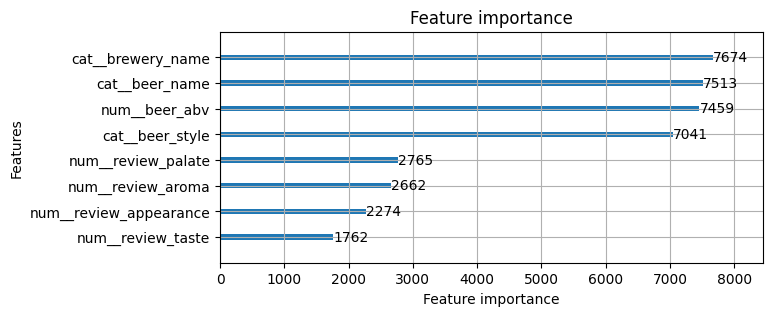

In [20]:
lgb.plot_importance(model, figsize=(7,3))

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

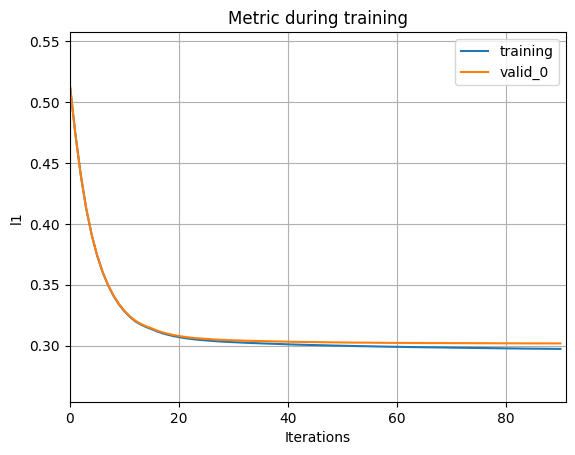

In [21]:
lgb.plot_metric(model,
                metric='l1')

In [22]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'beer_abv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                               min_data_in_leaf=124, min_data_per_group=71,
                               min_gain_to_split=0.03241647793618352,
                               min_sum_hessian_in_leaf=7.199265950431342,
                               n_estimator=1000, n_estimators=91,
                               num_leaves=436, other_rate=0.4662439412675177,
                               path_smooth=0.43557172372914066,
                               scale_pos_weight=1.886846809614612,
                               top_rate=0.38740874375559464,
                               tweedie_variance_power=1.8911146456348016,
                               verbose=-1))])

In [23]:
joblib.dump(model, 'Beer_reviews.pkl')

['Beer_reviews.pkl']

In [24]:
import shutil

shutil.move('Beer_reviews.pkl', '/kaggle/working/Beer_reviews.pkl')

'/kaggle/working/Beer_reviews.pkl'

In [25]:
load_model = joblib.load('Beer_reviews.pkl')
load_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'beer_abv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_e...
                               min_data_in_leaf=124, min_data_per_group=71,
                               min_gain_to_split=0.03241647793618352,
                               min_sum_hessian_in_leaf=7.199265950431342,
                               n_estimator=1000, n_estimators=91,
                               num_leaves=436, other_rate=0.4662439412675177,
                               path_smooth=0.43557172372914066,
                               scale_pos_weight=1.886846809614612,
                               top_rate=0.38740874375559464,
                               tweedie_variance_power=1.8911146456348016,
                               verbose=-1))])